In [1]:
%matplotlib notebook

import os
import re
import fnmatch
import numpy as np

from sklearn.model_selection import train_test_split
import scipy.io.wavfile as wav

import matplotlib.pyplot as plt
plt.ioff()

from python_speech_features import mfcc

from sklearn.utils import shuffle
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

from collections import Counter

import logging

In [2]:
# Define constants
DATA_ROOT = 'data/good_quality'
TRAIN_TEST_SPLIT_PCT = 0.3

RANDOM_STATE = 12345

MFCC_WINLEN = 0.025
MFCC_WINSTEP = 0.01

DELTA_PAD_IN_SEC = 0.05
DELTA_PARAM = 10
CONTEXT_LEN = 4

<hr>
<strong>Dataset loading and parsing</strong>

In [3]:
def get_dataset(root_dir):
    # Get all files
    data_files = os.listdir(root_dir)

    # Get unique labels; discard device info
    pattern = '[0-9]+_(.*).txt'
    dataset = list()
    for data_file in data_files:
        if re.match(pattern, data_file):
            dataset.append({
                'label': data_file
            })

    # Append data files to list of dict
    for counter, data in enumerate(dataset):
        label = data['label'].split('.txt')[0]
        matching_data = fnmatch.filter(data_files, label + '*.wav')
        dataset[counter]['signal'] = matching_data[0]

    # Perform train/test split
    dataset_train, dataset_test = train_test_split(dataset, test_size=TRAIN_TEST_SPLIT_PCT, random_state=RANDOM_STATE)
    
    return dataset_train, dataset_test

In [4]:
# Parse and split files into train and test sets
root_dir = os.path.abspath(DATA_ROOT)
dataset_train, dataset_test = get_dataset(root_dir)

# Print top of the list
dataset_train[:5]

[{'label': '266710_23_M_16_4.txt', 'signal': '266710_23_M_16_4.wav'},
 {'label': '266708_23_M_21_1.txt', 'signal': '266708_23_M_21_1.wav'},
 {'label': '273352_23_M_21_6.txt', 'signal': '273352_23_M_21_6.wav'},
 {'label': '273352_23_M_10_4.txt', 'signal': '273352_23_M_10_4.wav'},
 {'label': '266712_23_K_12_2.txt', 'signal': '266712_23_K_12_2.wav'}]

In [5]:
def read_data(data, root):
    # Read samples
    temp_path = os.path.join(root, data['signal'])
    srate, samples = wav.read(temp_path)

    # Create time vector
    time = np.linspace(0, (len(samples)-1)/srate, len(samples))

    # Parse command labels
    temp_path = os.path.join(root, data['label'])
    pause = list()
    with open(temp_path) as f:
        labels = [line.split('\t') for line in f]
        for label in labels:
            label[0] = float(label[0])
            label[1] = float(label[1])
            label[2] = label[2].split('\n')[0]

            # Build pause segments from signal portions between commands
            if len(pause):
                pause[-1][1] = label[0]
            pause.append([
                label[1],
                0,
                '-'
            ])

    # Remove last element and append to labels
    pause.pop()
    labels += pause

    # Assign signal segments to each command
    segments = list()
    targets = list()
    for label in labels:
        targets.append(label[2])
        segments.append(
            samples[(time >= label[0] - DELTA_PAD_IN_SEC) & (time <= label[1] + DELTA_PAD_IN_SEC)]
        )
    
    # Create sampling rate list
    srate_list = [srate for _ in targets]
        
    return segments, targets, srate_list

C:\Users\Mateusz\Miniconda3\envs\voice_reco\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


<IPython.core.display.Javascript object>


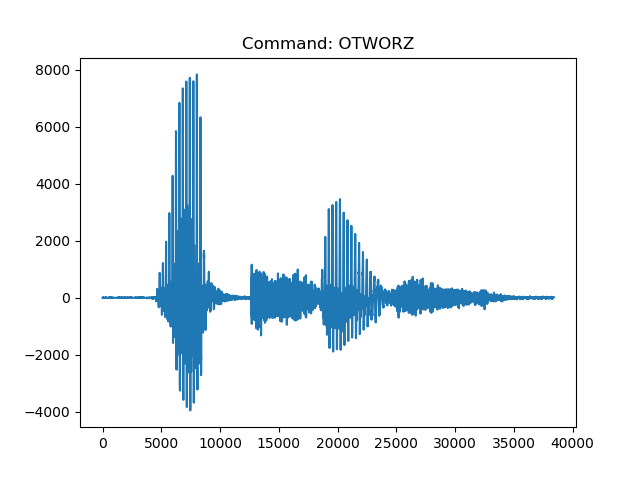

In [6]:
# Initialize
segments_list = list()
targets_list = list()
srate_list = list()

# Parse signal-label pairs
for data in dataset_train:
    segments, targets, srate = read_data(data, root_dir)
    segments_list += segments
    targets_list += targets
    srate_list += srate
    
# Display an exemplary time series
plt.plot(segments_list[0])
plt.title('Command: ' + targets_list[0])
plt.show()

<hr>
<strong>Feature extraction</strong><br><br>
References on MFCC:<br>
<ul>
    <li>http://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html</li>
<li>http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/</li>
    </ul>

In [7]:
def get_mfcc_features(signal, srate, winlen, winstep, delta_param):
    # Mute warning stdout
    logging.getLogger().setLevel(logging.ERROR)
    
    # Calculate MFCC features for a single command signal segment
    mfcc_features = mfcc(signal, srate, winlen=winlen, winstep=winstep, winfunc=np.hamming)
    mfcc_features = np.asarray(mfcc_features)

    # Calculate MFCC deltas
    if delta_param > 0:
        d_numerator = list()
        d_denominator = list()
        for n in range(1, delta_param + 1):
            result = n * (mfcc_features[2*n:] - mfcc_features[:-2*n])
            if len(d_numerator) == 0:
                d_numerator = result
                d_denominator = 2 * (n ** 2)
            else:
                d_numerator = d_numerator[1:-1] + result
                d_denominator += 2 * (n ** 2)
        delta_features = d_numerator / d_denominator

        # Merge MFCC and deltas
        features = np.concatenate((mfcc_features[delta_param:-delta_param], delta_features), axis=1)
        
    else:
        features = mfcc_features
    
    # Reset stdout
    logging.getLogger().setLevel(logging.NOTSET)
    
    return features

<IPython.core.display.Javascript object>


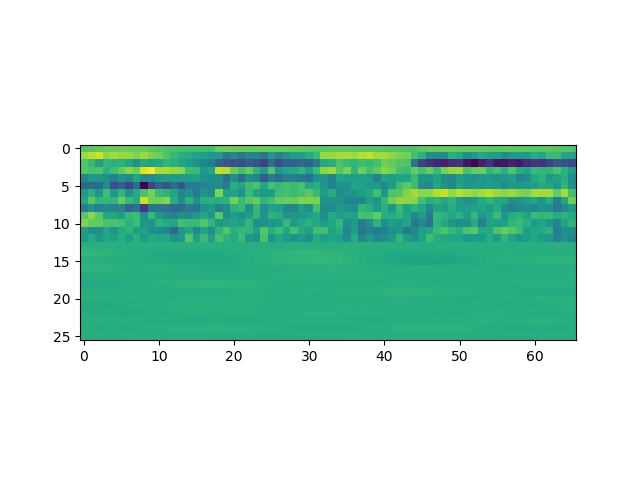

In [8]:
# Initialize
features_list = list()

# Transform signal to MFCC features
for idx in range(len(segments_list)):
    features = get_mfcc_features(segments_list[idx], srate_list[idx], MFCC_WINLEN, MFCC_WINSTEP, DELTA_PARAM)
    features_list.append(features)

# Display an exemplary MFCC image
plt.imshow(features_list[0].T)
plt.show()

<hr>
<strong>Word tag model</strong>

Let's assume a simple, word-based speech model. 

Each target word is divided into three underlying states: 
<ui>
    <li>&lt;WORD START&gt;,</li>
    <li>&lt;WORD MIDDLE&gt;, </li>
    <li>&lt;WORD END&gt;.</li>
</ui>

Let's further assume that WORD START and WORD END states correspond to first- and last two letters in a word, respectively. WORD MIDDLE then corresponds to every single letter in between these two boundary values, for example the word <em>SWIATLO</em> can be decomposed as <br>[(SW), (I), (A), (T), (LO)] <br>which in turn is modelled as the sequence <br>[(WORD START), 3x(WORD MIDDLE), (WORD END)]. 

In case of words with fewer than four letters the following models are used:
<ui>
    <li>3 letters -> [2x(WORD START), (WORD END)]</li>
    <li>2 letters -> [(WORD START), (WORD END)]</li>
    <li>1 letters -> [(WORD START), (WORD END)]</li> 
</ui>

Based on the aforementioned models, each MFCC feature set is evenly divided into non-overlapping windows.

Pause symbol ('-') is not decomposed.

In [9]:
def parse_command(command):
    if command == '-':
        # Leave pause command as-is
        return [command]
    else:
        # Prepare tags
        word_start = '<{} START>'.format(command)
        word_middle = '<{} MIDDLE>'.format(command)
        word_end = '<{} END>'.format(command)
        
        # Decompose words and model them with tags
        word_len = len(command)
        if word_len < 3:
            return [word_start, word_end]
        elif word_len < 4:
            return [word_start, word_start, word_end]
        else:
            output_list = list()
            output_list.append(word_start)
            for _ in range(word_len-4):
                output_list.append(word_middle)
            output_list.append(word_end)
            return output_list           

In [10]:
# Initialize
tags_list = list()

# Model words using <START>, <MIDDLE> and <END> tags
for target in targets_list:
    tag = parse_command(target)
    tags_list.append(tag)

# Print top of the list
tags_list[:3]

[['<OTWORZ START>', '<OTWORZ MIDDLE>', '<OTWORZ MIDDLE>', '<OTWORZ END>'],
 ['<ZAMKNIJ START>',
  '<ZAMKNIJ MIDDLE>',
  '<ZAMKNIJ MIDDLE>',
  '<ZAMKNIJ MIDDLE>',
  '<ZAMKNIJ END>'],
 ['<GARAZ START>', '<GARAZ MIDDLE>', '<GARAZ END>']]

In [11]:
def split_mfcc_features(features, tags, context_len):
    # Split feature matrix into frames with neighbouring context window of length context_len
    frames = list()
    for idx in range(context_len, len(features)-context_len):
        frame = np.asarray(features[idx-context_len:idx+context_len+1])
        frames.append(frame.flatten())
    
    # Initialize output lists
    context_list = list()
    command_list = list()
    
    if tags[0] == '-':
        # Pause found; associate with each frame
        for frame in frames:
            context_list.append(frame)
            command_list.append('-')
            
    else:
        # Calculate number of frames associated with each tag
        num_frames, num_frames_remainder = divmod(len(frames), len(tags))
        indexes = [[idx*num_frames, (idx+1)*num_frames] for idx in range(len(tags))]
        
        # Update last two tags so that remainder should go to either START or MIDDLE tags
        indexes[-2][1] += num_frames_remainder
        indexes[-1] = [value+num_frames_remainder for value in indexes[-1]]

        # Associate frames with tags
        for tag_idx in range(len(tags)):
            frame_range = range(indexes[tag_idx][0], indexes[tag_idx][1])
            for frame_idx in frame_range:
                context_list.append(frames[frame_idx])
                command_list.append(tags[tag_idx])
    
    return context_list, command_list

In [12]:
# Initialize
training_samples = list()
training_targets = list()

# Associate MFCC feature frames with word tags
for idx in range(len(features_list)):
    context_list, command_list = split_mfcc_features(features_list[idx], tags_list[idx], CONTEXT_LEN)
    training_samples += context_list
    training_targets += command_list

# Print details about training set
print('Number of training examples: {}.\nNumber of features: {}.'.format(
    np.shape(training_samples)[0], np.shape(training_samples)[1]
))

Number of training examples: 50930.
Number of features: 234.


In [13]:
# Create a pipeline from previously defined functions
def preprocessing_pipeline(dataset):
    
    # Initialize
    segments_list = list()
    targets_list = list()
    srate_list = list()
    
    features_list = list()
    tags_list = list()
    
    x_data = list()
    y_data = list()

    # Parse signal-label pairs
    for data in dataset:
        segments, targets, srate = read_data(data, root_dir)
        segments_list += segments
        targets_list += targets
        srate_list += srate

    # Transform signal to MFCC features
    for idx in range(len(segments_list)):
        features = get_mfcc_features(segments_list[idx], srate_list[idx], MFCC_WINLEN, MFCC_WINSTEP, DELTA_PARAM)
        features_list.append(features)
        
    # Model words using <START>, <MIDDLE> and <END> tags
    for target in targets_list:
        tag = parse_command(target)
        tags_list.append(tag)

    # Associate MFCC feature frames with word tags
    for idx in range(len(features_list)):
        context_list, command_list = split_mfcc_features(features_list[idx], tags_list[idx], CONTEXT_LEN)
        x_data += context_list
        y_data += command_list
        
    # Print details about preprocessed dataset
    print('Number of examples: {}.\nNumber of features: {}.'.format(
        np.shape(x_data)[0], np.shape(x_data)[1]
    ))
    
    return x_data, y_data

In [14]:
# Preprocess test data
test_x, test_y = preprocessing_pipeline(dataset_test)

C:\Users\Mateusz\Miniconda3\envs\voice_reco\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


Number of examples: 16815.
Number of features: 234.


<hr>
<strong>MLP classifier</strong>

In order to employ a HMM model for voice recognition, we first need to estimate emission probabilities of observations (audio signal segment discretized into word tags) given a hidden state (spoken command). Emission probabilities are estimated using MLP classifier output scaled by prior probabilities of word tags (from frequency count of word tags).

In [15]:
def shuffle_lists(list_a, list_b, random_seed):
    randomizer = np.random.RandomState(random_seed)
    
    indices = np.arange(len(list_a))
    randomizer.shuffle(indices)
    
    return np.asarray(list_a)[indices], np.asarray(list_b)[indices]

# Randomize training dataset
train_x, train_y = shuffle_lists(training_samples, training_targets, random_seed=RANDOM_STATE)

# Standardize features
scaler = StandardScaler()
scaler.fit(train_x)
train_x = scaler.transform(train_x)
test_x = scaler.transform(test_x)

In [16]:
# Define the model
classifier = MLPClassifier(
    solver='adam', 
    activation='relu',
    alpha=2e-1,
    hidden_layer_sizes=(256), 
    random_state=RANDOM_STATE,
    max_iter=200,
    learning_rate_init=1e-3,
    early_stopping=True,
    validation_fraction=0.3,
    learning_rate='adaptive',
    verbose=True,
)

# Train the model
classifier.fit(train_x, train_y)

# Check prediction accuracy on training data
training_accuracy = classifier.score(train_x, train_y)
print('Training set accuracy: {0:.2f}%'.format(100*training_accuracy))

# Check prediction accuracy on test data
test_accuracy = classifier.score(test_x, test_y)
print('Test set accuracy: {0:.2f}%'.format(100*test_accuracy))

Iteration 1, loss = 1.41750906
Validation score: 0.787093
Iteration 2, loss = 0.78937805
Validation score: 0.845932
Iteration 3, loss = 0.61386965
Validation score: 0.875712
Iteration 4, loss = 0.51981754
Validation score: 0.894168
Iteration 5, loss = 0.46445097
Validation score: 0.909091
Iteration 6, loss = 0.42570528
Validation score: 0.916618
Iteration 7, loss = 0.39702867
Validation score: 0.923032
Iteration 8, loss = 0.37399840
Validation score: 0.929838
Iteration 9, loss = 0.35719808
Validation score: 0.933111
Iteration 10, loss = 0.34458411
Validation score: 0.934812
Iteration 11, loss = 0.33431498
Validation score: 0.938870
Iteration 12, loss = 0.32484932
Validation score: 0.942928
Iteration 13, loss = 0.31701391
Validation score: 0.941423
Iteration 14, loss = 0.31171542
Validation score: 0.945873
Iteration 15, loss = 0.30597580
Validation score: 0.947117
Iteration 16, loss = 0.30167178
Validation score: 0.946724
Iteration 17, loss = 0.29777577
Validation score: 0.946593
Iterat

In [17]:
# Get labels normalizing constant (weigh by their relative frequency)
def get_label_probab(labels_list):
    num_elements = float(len(labels_list))
    label_probab = Counter(labels_list)
    for label in label_probab.keys():
        label_probab[label] = label_probab[label]/num_elements
    return label_probab

def get_label_scores(labels_list, label_probab):
    if 1:
        scores = [1/label_probab[target] for target in labels_list]
    else:
        scores = list()
        for target in labels_list:
            print(target)
            scores.append(1/label_probab[target])
    return scores

# Get word tag relative frequencies (~prior probabilities)
word_tag_priors = get_label_probab(train_y)

# Get weighted accuracy measure - training data
training_accuracy_weighted = classifier.score(train_x, train_y, get_label_scores(train_y, word_tag_priors))
print('Weighted training set accuracy: {0:.2f}%'.format(100*training_accuracy_weighted))

# Get weighted accuracy measure - test data
test_accuracy_weighted = classifier.score(test_x, test_y, get_label_scores(test_y, word_tag_priors))
print('Weighted test set accuracy: {0:.2f}%'.format(100*test_accuracy_weighted))

Weighted training set accuracy: 94.31%
Weighted test set accuracy: 72.04%


<hr>
<strong>Single dataset tests</strong><br>

Hall of fame (~70% raw accuracy or ~50% weighted on initial model):
<ul>
    <li>258135</li>
    <li>266702</li>
    <li>266708</li>
    <li>266710</li>
    <li>266711</li>
    <li>266712</li>
    <li>266723</li>
    <li>273352</li>
    <li>273356</li>
</ul>

Hall of shame
<ul>
    <li>258118 (typo in MUZYKE in 258118_25_K_06.23.txt)</li>
    <li>258126 (typo in ZAMKNIJ in 258126_24_K_3_4.txt)</li>
    <li>266701 (comma =/= dot)</li>
    <li>266710 (266710_23_M_10_1.txt has 'ď»ż' characters)</li>
    <li>266711 (Polish characters, words not in CAPS; files have 'ď»ż' characters)</li>
    <li>266712 (non-ANSI encoding of 266712_23_K_23_4.txt)</li>
    <li>273352 (comma =/= dot)</li>
</ul>

<hr>
<strong>Big dataset tests</strong>

<pre>

Model parameters:

    MFCC_WINLEN = 0.025
    MFCC_WINSTEP = 0.01
    DELTA_PAD_IN_SEC = 0.05
    DELTA_PARAM = 10
    CONTEXT_LEN = 4

    classifier = MLPClassifier(
        solver='adam', 
        activation='relu',
        alpha=2e-1,
        hidden_layer_sizes=(256), 
        random_state=RANDOM_STATE,
        max_iter=200,
        learning_rate_init=1e-3,
        early_stopping=True,
        validation_fraction=0.3,
        learning_rate='adaptive',
        verbose=True,
    )

Good_quality:

    Training set accuracy: 97.88%
    Test set accuracy: 87.26%

    Weighted training set accuracy: 94.31%
    Weighted test set accuracy: 72.04%
    
Full:

    Training set accuracy: 91.40%
    Test set accuracy: 68.37%
    
    Weighted training set accuracy: 83.07%
    Weighted test set accuracy: 44.74%

</pre>

<hr>